In [214]:
from typing import List, Tuple
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import pandas as pd
import base64
from io import BytesIO

outputs = [
    "1000000000",  # 1
    "0100000000",  # 2
    "0010000000",  # 3
    "0001000000",  # 4
    "0000100000",  # 5
    "0000010000",  # 6
    "0000001000",  # 7
    "0000000100",  # 8
    "0000000010",  # 9
    "0000000001",  # 0
]

In [215]:
class NeuralNetwork(nn.Module):
    def __init__(self, nnets: int):
        super(NeuralNetwork, self).__init__()
        # first layer nnets neurons and tanh activation
        self.fc1 = nn.Linear(20, nnets)
        self.fc1.activation = nn.Tanh()
        # second layer 10 neurons and linear activation
        self.fc2 = nn.Linear(nnets, 10)

        # the exit from the last layer a number between 0 and 1
        self.fc2.activation = nn.Sigmoid()

    

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        sigmoid = nn.Sigmoid()
        x = sigmoid(x)
        return x

In [216]:
def read_tiles_from_image(image_path: str) -> List[List[int]]:
    # open the image "numeros.png"
    img = Image.open(image_path)
    # the image is a 40 x 5 image
    # split the image into 10 4 x 5 images

    # convert the image to black and white
    img = img.convert("1")

    numbers = []
    for i in range(10):
        # crop the image
        numbers.append(img.crop((i * 4, 0, (i + 1) * 4, 5)))

    # create a list of bit strips of the numbers
    # the index of the list is the number
    numbers_list = []
    for i in range(10):
        numbers_list.append([])
        for j in range(5):
            for k in range(4):
                numbers_list[i].append(0 if numbers[i].getpixel((k, j)) == 255 else 1)

    print("Pixels of the numbers in the image:")
    for i in numbers_list:
        print("".join(str(x) for x in i))

    return numbers_list

In [217]:
def bits_to_img(bits: List[int]) -> Image:
    img = Image.new("1", (4, 5))
    for i in range(5):
        for j in range(4):
            img.putpixel(
                (
                    j,
                    i,
                ),
                255 if bits[i * 4 + j] == 0 else 0,
            )
    # resize the image to 40 x 50
    img = img.resize((40, 50))
    return img


def img_to_base64(img: Image) -> str:
    with BytesIO() as buffer:
        img.save(buffer, "PNG")
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(base64img: str) -> str:
    return f'<img style="display:inline-block; width: 50px; height: 50px; margin: 0px; image-rendering: pixelated;" src="data:image/png;base64,{base64img}">'


def bits_tensor_to_printable(bits: List[int]) -> str:
    img = bits_to_img(bits)
    base64img = img_to_base64(img)
    return image_formatter(base64img)

In [218]:
def train_network(
    input_tensors: torch.Tensor,
    output_tensors: torch.Tensor,
    nnets: int,
    epochs: int,
    goal: float,
    learning_rate: float,
    momentum: float,
) -> Tuple[NeuralNetwork, pd.DataFrame]:
    # Mean Squared Loss
    criterion = nn.MSELoss()
    model = NeuralNetwork(nnets)
    # stochastic gradient descent
    optimizer = optim.SGD(  # Stochastic Gradient Descent/Gradient Descent with Momentum (TRAINGDM Equivalent)
        model.parameters(), lr=learning_rate, momentum=momentum
    )

    history_data = pd.DataFrame(
        columns=["nnets", "epoch", "goal", "learning_rate", "momentum"]
    )

    history_data = pd.concat(
        [
            history_data,
            pd.DataFrame(
                [{
                    "nnets": nnets,
                    "epoch": 0,
                    "goal": goal,
                    "learning_rate": learning_rate,
                    "momentum": momentum,
                }]
            ),
        ],
        ignore_index=True,
    )
    print(f"""nnets {nnets}
epochs {epochs}
goal {goal}
learning_rate {learning_rate}
momentum {momentum}""")

    # Train the neural network
    for epoch in range(epochs):
        # Forward pass
        outputs = model(input_tensors)

        loss = criterion(outputs, output_tensors)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        history_data = pd.concat(
            [
                history_data,
                pd.DataFrame(
                    [{
                        "nnets": nnets,
                        "epoch": epoch,
                        "goal": goal,
                        "learning_rate": learning_rate,
                        "momentum": momentum,
                    }]
                ),
            ],
            ignore_index=True,
        )

        if epoch % 1000 == 0:
            print(
                f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}, Learning Rate: {learning_rate}, Momentum: {momentum}"
            )

        if loss.item() < goal:
            break

    print(f"Final loss: {loss.item():.6f}")
    return model, history_data


In [219]:
def flip_n_bits(bits: torch.Tensor, n: int = 1) -> torch.Tensor:
    import random

    randomIdxs = random.sample(range(0, len(bits)), n)
    for i in randomIdxs:
        bits[i] = 1 if bits[i] == 0 else 0
    return bits

In [220]:
from numpy import mean


def test_network(
    model: NeuralNetwork,
    input_tensors: List[torch.Tensor],
    expected_output_tensors: List[torch.Tensor],
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # make a copy of the original input tensors
    original_input_tensors = input_tensors.clone()

    # create a dataframe to store the test results
    test_results_0 = pd.DataFrame(
        columns=[
            "input",
            "correct_output",
            "prediction",
            "is_correct",
            "n_wrong_bits",
        ]
    )
    test_results_1 = test_results_0.copy()
    test_results_2 = test_results_0.copy()
    test_results_3 = test_results_0.copy()

    # TODO: find a better name to this function
    def this_test(
        model: NeuralNetwork,
        input_tensor: torch.Tensor,
        correct_output: torch.Tensor,
        test_results: pd.DataFrame,
        n_wrong_bits: int,
    ):
        with torch.no_grad():
            input_tensor = flip_n_bits(input_tensor, n_wrong_bits)
            outputs: torch.Tensor = model(input_tensor)
            
            sigmoid = nn.Sigmoid()
            outputs = sigmoid(outputs)

            correctness = torch.mean(outputs - correct_output)
            # convert to float
            correctness =  correctness.item()
            correctness = round(correctness, 2)

            test_results = pd.concat(
                [
                    test_results,
                    pd.DataFrame(
                        [
                            {
                                "input": input_tensor,
                                "correct_output": correct_output,
                                "prediction": outputs,
                                "is_correct": correctness,
                                "n_wrong_bits": n_wrong_bits,
                            }
                        ]
                    ),
                ],
                ignore_index=True,
            )

        return test_results

    # Test the neural network
    print("Testing the neural network")
    for i in range(len(input_tensors)):
        test_results_0 = this_test(
            model,
            input_tensors[i],
            expected_output_tensors[i],
            test_results_0,
            0,
        )

    input_tensors = original_input_tensors.clone()
    # flip 1 bit in each input and test again
    print("Testing the neural network with 1 bit flipped in each input")
    for i in range(len(input_tensors)):
        test_results_1 = this_test(
            model,
            input_tensors[i],
            expected_output_tensors[i],
            test_results_1,
            1,
        )

    input_tensors = original_input_tensors.clone()
    # flip 2 bits in each input and test again
    print("Testing the neural network with 2 bits flipped in each input")
    for i in range(len(input_tensors)):
        test_results_2 = this_test(
            model,
            input_tensors[i],
            expected_output_tensors[i],
            test_results_2,
            2,
        )

    input_tensors = original_input_tensors.clone()
    # flip 3 bits in each input and test again
    print("Testing the neural network with 3 bits flipped in each input")
    for i in range(len(input_tensors)):
        test_results_3 = this_test(
            model,
            input_tensors[i],
            expected_output_tensors[i],
            test_results_3,
            3,
        )

    return test_results_0, test_results_1, test_results_2, test_results_3


In [221]:
def tests(
    input_tensors: torch.Tensor, output_tensors: torch.Tensor
) -> Tuple[List[pd.DataFrame], List[pd.DataFrame]]:
    train_params = [
        {"epochs": 10000, "goal": 0.0005, "learning_rate": 0.1, "momentum": 0.0},
        {"epochs": 10000, "goal": 0.0005, "learning_rate": 0.4, "momentum": 0.0},
        {"epochs": 10000, "goal": 0.0005, "learning_rate": 0.9, "momentum": 0.0},
        {"epochs": 10000, "goal": 0.0005, "learning_rate": 0.1, "momentum": 0.4},
        {"epochs": 10000, "goal": 0.0005, "learning_rate": 0.9, "momentum": 0.4},
    ]
    neural_networks = [15, 25, 35]

    train_history_data_frames: List[pd.DataFrame] = []

    test_results_data_frames: List[pd.DataFrame] = []

    for nnets in neural_networks:
        for params in train_params:
            epochs = params["epochs"]
            goal = params["goal"]
            learning_rate = params["learning_rate"]
            momentum = params["momentum"]

            # Train the neural network
            trained_model, model_history = train_network(
                input_tensors,
                output_tensors,
                nnets,
                epochs,
                goal,
                learning_rate,
                momentum,
            )
            train_history_data_frames.append(model_history)

            # Test the neural network
            (
                test_results_0,
                test_results_1,
                test_results_2,
                test_results_3,
            ) = test_network(trained_model, input_tensors, output_tensors)
            test_results_data_frames.append(test_results_0)
            test_results_data_frames.append(test_results_1)
            test_results_data_frames.append(test_results_2)
            test_results_data_frames.append(test_results_3)

    return train_history_data_frames, test_results_data_frames

In [222]:
data = read_tiles_from_image("numeros.png")
len(data)

Pixels of the numbers in the image:
01001100010001001110
01101001001001001111
11100001001000011110
10101010111100100010
11111000111000011110
01111000111010010110
11110001001001000100
01101001011010010110
01101001011100011111
01101001100110010110


10

In [223]:
input_tensor = torch.tensor(data, dtype=torch.float)
input_tensor 
len(input_tensor)

10

In [224]:
correct_output = torch.tensor(
    [list(map(int, outp)) for outp in outputs], dtype=torch.float
)
correct_output

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [225]:
train_history_data_frames, test_results_data_frames = tests(
    input_tensor, correct_output
)

Epoch [0/10000], Loss: 0.262252, Learning Rate: 0.1, Momentum: 0.0
Epoch [1000/10000], Loss: 0.075955, Learning Rate: 0.1, Momentum: 0.0
Epoch [2000/10000], Loss: 0.051484, Learning Rate: 0.1, Momentum: 0.0
Epoch [3000/10000], Loss: 0.031139, Learning Rate: 0.1, Momentum: 0.0
Epoch [4000/10000], Loss: 0.015328, Learning Rate: 0.1, Momentum: 0.0
Epoch [5000/10000], Loss: 0.007500, Learning Rate: 0.1, Momentum: 0.0
Epoch [6000/10000], Loss: 0.004333, Learning Rate: 0.1, Momentum: 0.0
Epoch [7000/10000], Loss: 0.002864, Learning Rate: 0.1, Momentum: 0.0
Epoch [8000/10000], Loss: 0.002069, Learning Rate: 0.1, Momentum: 0.0
Epoch [9000/10000], Loss: 0.001588, Learning Rate: 0.1, Momentum: 0.0
Final loss: 0.001271
Testing the neural network
Testing the neural network with 1 bit flipped in each input
Testing the neural network with 2 bits flipped in each input
Testing the neural network with 3 bits flipped in each input
Epoch [0/10000], Loss: 0.228424, Learning Rate: 0.4, Momentum: 0.0
Epoch 

In [226]:
def tensor_to_string(tensor: torch.Tensor) -> str:
    return ",".join(map(str, map(lambda x: round(float(x)), tensor)))

,0,input,input zero,correctness zero,input one,correctness one,input two,correctness two,input three,correctness three
0,input,,,0.01,,0.02,,0.01,,-0.05
1,input zero,,,0.01,,0.00,,-0.02,,-0.03
2,correctness zero,,,0.01,,0.00,,0.07,,-0.03
3,input one,,,0.01,,0.04,,-0.02,,-0.06
4,correctness one,,,0.01,,0.00,,0.00,,-0.03
5,input two,,,0.01,,0.01,,-0.03,,-0.03
6,correctness two,,,0.01,,-0.00,,-0.05,,0.05
7,input three,,,0.01,,-0.01,,0.01,,-0.04
8,correctness three,,,0.01,,0.03,,0.04,,-0.02
,0,input,input zero,correctness zero,input one,correctness one,input two,correctness two,input three,correctness three

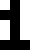
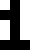
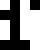
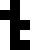
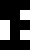
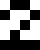
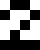
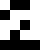
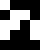
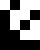
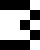
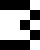
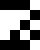
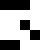
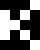
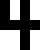
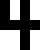
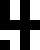
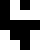
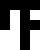
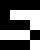
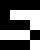
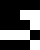
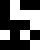
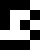
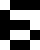
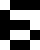
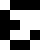
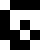
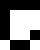
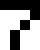
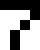
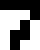
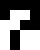
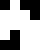
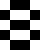
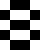
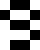
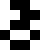
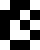
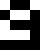
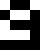
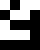
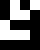
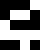
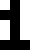
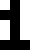
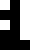
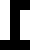
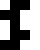
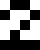
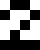
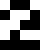
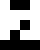
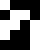
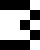
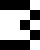
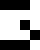
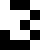
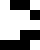
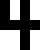
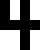
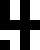
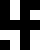
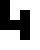
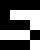
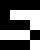
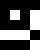
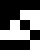
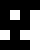
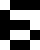
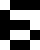
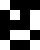
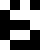
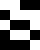
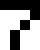
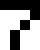
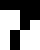
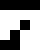
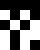
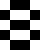
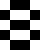
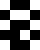
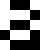
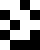
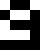
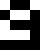
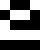
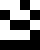
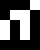
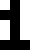
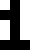
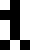
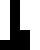
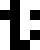
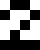
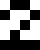
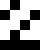
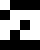
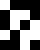
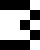
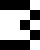
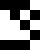
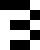
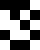
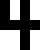
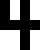
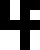
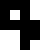
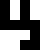
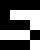
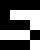
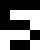
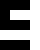
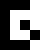
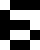
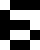
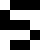
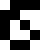
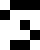
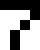
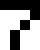
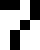
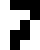
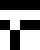
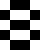
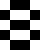
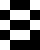
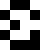
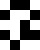
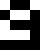
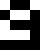
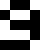
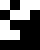
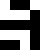
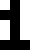
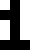
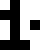
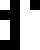
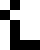
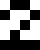
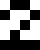
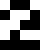
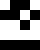
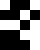
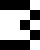
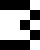
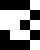
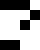
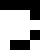
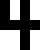
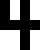
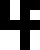
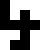
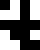
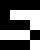
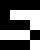
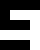
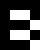
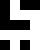
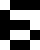
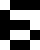
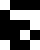
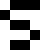
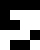
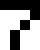
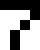
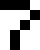
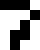
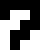
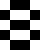
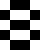
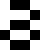
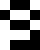
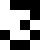
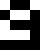
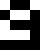
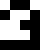
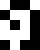
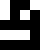
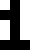
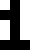
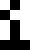
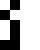
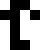
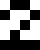
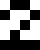
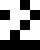
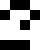
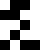
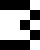
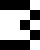
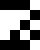
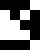
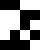
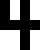
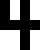
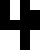
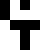
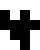
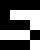
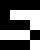
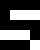
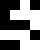
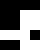
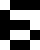
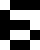
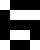
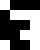
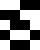
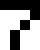
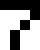
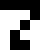
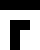
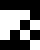
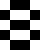
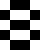
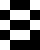
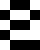
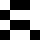
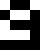
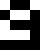
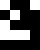
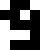
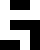
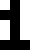
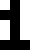
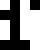
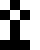
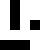
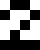
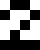
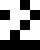
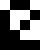
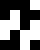
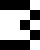
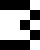
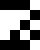
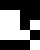
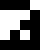
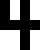
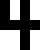
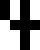
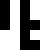
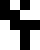
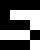
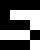
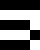
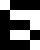
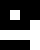
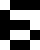
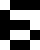
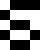
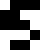
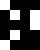
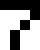
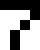
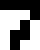
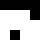
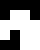
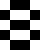
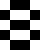
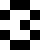
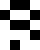
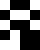
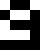
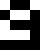
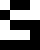
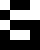
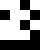
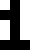
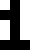
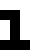
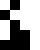
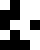
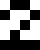
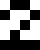
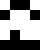
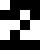
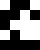
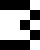
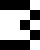
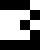
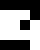
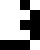
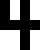
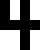
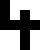
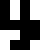
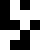
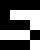
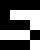
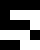
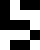
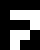
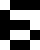
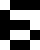
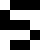
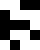
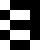
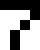
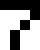
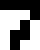
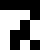
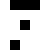
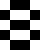
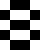
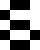
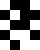
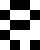
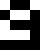
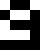
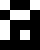
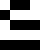
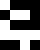
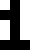
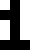
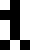
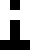
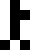
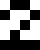
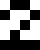
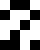
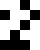
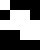
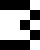
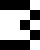
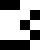
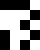
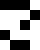
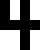
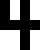
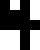
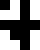
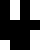
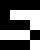
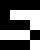
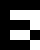
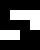
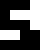
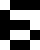
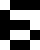
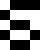
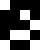
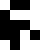
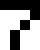
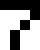
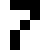
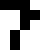
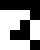
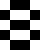
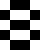
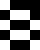
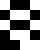
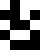
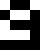
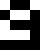
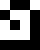
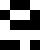
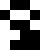
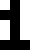
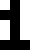
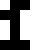
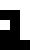
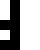
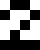
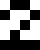
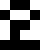
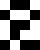
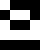
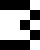
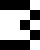
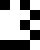
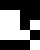
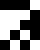
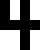
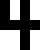
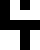
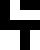
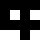
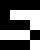
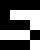
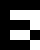
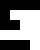
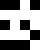
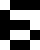
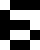
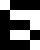
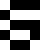
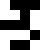
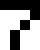
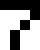
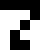
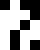
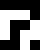
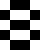
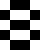
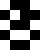
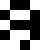
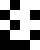
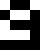
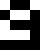
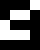
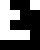
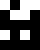
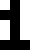
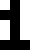
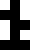
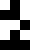
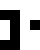
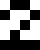
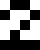
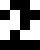
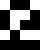
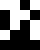
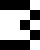
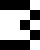
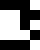
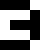
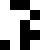
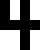
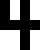
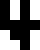
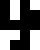
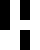
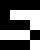
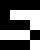
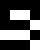
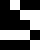
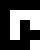
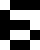
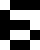
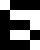
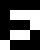
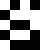
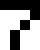
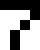
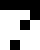
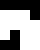
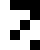
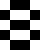
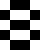
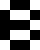
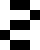
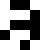
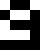
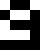
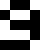
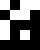
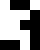
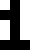
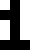
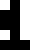
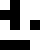
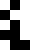
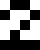
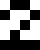
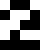
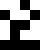
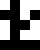
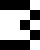
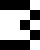
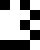
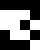
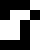
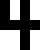
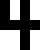
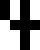
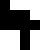
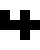
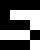
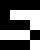
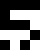
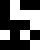
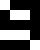
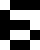
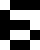
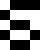
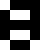
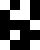
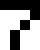
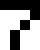
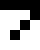
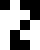
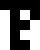
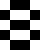
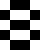
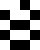
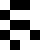
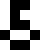
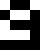
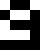
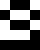
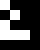
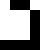
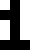
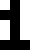
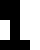
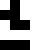
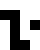
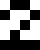
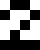
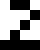
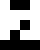
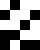
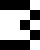
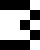
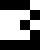
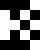
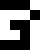
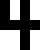
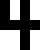
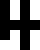
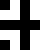
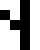
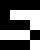
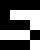
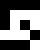
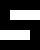
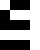
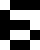
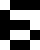
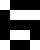
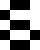
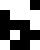
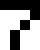
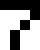
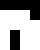
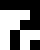
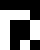
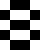
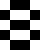
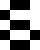
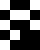
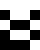
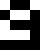
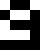
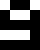
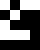
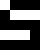
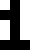
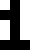
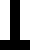
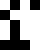
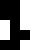
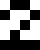
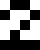
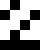
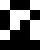
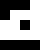
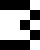
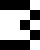
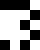
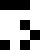
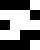
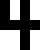
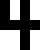
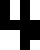
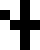
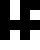
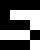
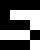
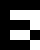
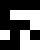
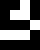
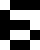
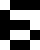
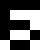
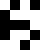
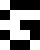
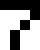
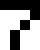
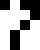
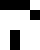
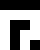
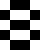
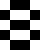
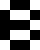
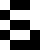
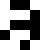
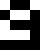
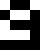
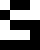
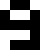
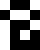
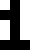
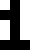
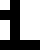
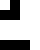
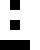
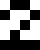
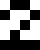
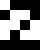
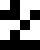
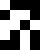
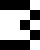
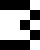
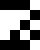
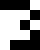
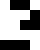
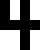
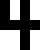
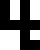
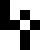
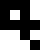
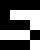
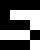
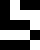
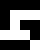
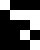
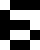
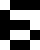
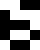
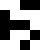
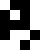
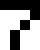
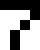
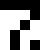
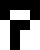
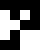
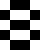
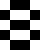
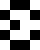
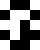
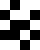
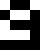
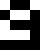
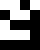
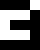
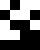
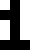
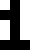
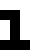
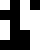
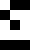
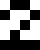
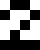
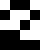
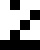
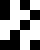
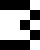
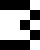
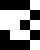
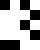
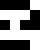
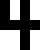
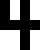
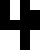
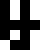
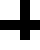
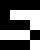
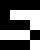
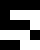
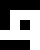
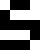
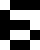
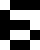
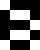
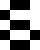
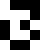
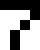
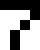
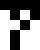
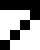
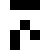
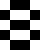
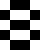
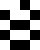
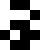
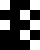
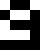
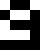
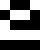
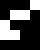
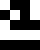

In [227]:
all_results = ""

for index in range(0,len(test_results_data_frames), 4):
    zero_wrong_bits = test_results_data_frames[index]
    one_wrong_bits = test_results_data_frames[index + 1]
    two_wrong_bits = test_results_data_frames[index + 2]
    three_wrong_bits = test_results_data_frames[index + 3]
    data_frame = pd.DataFrame(
        [
            "input",
            "input zero",
            "correctness zero",
            "input one",
            "correctness one",
            "input two",
            "correctness two",
            "input three",
            "correctness three",
        ]
    )

    data_frame["input"] = zero_wrong_bits["input"].apply(lambda x: bits_tensor_to_printable(x))
    data_frame["input zero"] = zero_wrong_bits["input"].apply(lambda x: bits_tensor_to_printable(x))
    data_frame["correctness zero"] = zero_wrong_bits["is_correct"]
    data_frame["input one"] = one_wrong_bits["input"].apply(lambda x: bits_tensor_to_printable(x))
    data_frame["correctness one"] = one_wrong_bits["is_correct"]
    data_frame["input two"] = two_wrong_bits["input"].apply(lambda x: bits_tensor_to_printable(x))
    data_frame["correctness two"] = two_wrong_bits["is_correct"]
    data_frame["input three"] = three_wrong_bits["input"].apply(lambda x: bits_tensor_to_printable(x))
    data_frame["correctness three"] = three_wrong_bits["is_correct"]
    
    html_code = data_frame.to_html(escape=False)
    all_results += html_code

HTML(all_results)
